In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [14]:
ls 'drive/My Drive/01_Qvalue/GenWaterCoolerH3.xlsx'

db1.py    GenAirCoolerH3.xlsx    ihTags.xlsx  query1.py
func1.py  GenWaterCoolerH3.xlsx  Q1.ipynb     ThrustCoolerH3.xlsx


In [10]:
!cp "drive/My Drive/01_Qvalue/func1.py" "func1.py"
!cp "drive/My Drive/01_Qvalue/db1.py" "db1.py"
!cp "drive/My Drive/01_Qvalue/query1.py" "query1.py"

In [27]:
import tensorflow as tf
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from func1 import *
# from query1 import *
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [46]:
df = pd.read_excel('drive/My Drive/01_Qvalue/GenWaterCoolerH3.xlsx')
df.head(2)

,timestamp,MW,MVAR,80GAW,F,26WIS,26WOS,dTemp,p,C,Q
0,2020-02-18 17:00:00,76.11,0.11,5310.83,0.06,26.33,30.40,4.06,996.6,4.1785,1497.57
1,2020-02-18 17:30:00,80.54,0.66,5095.16,0.06,26.13,30.07,3.93,996.6,4.1785,1390.82


In [47]:
print("raw of shape ", df.shape)

raw of shape  (2551, 11)


In [48]:
df.index = df['timestamp']
df.index = df.index.astype('datetime64[ns]')
df.sort_index(inplace=True)
df.dropna(inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head(2)

,timestamp,MW,MVAR,80GAW,F,26WIS,26WOS,dTemp,p,C,Q
timestamp,,,,,,,,,,,
2020-02-18 17:00:00,2020-02-18 17:00:00,76.11,0.11,5310.83,0.06,26.33,30.40,4.06,996.6,4.1785,1497.57
2020-02-18 17:30:00,2020-02-18 17:30:00,80.54,0.66,5095.16,0.06,26.13,30.07,3.93,996.6,4.1785,1390.82


In [49]:
df.tail(2)

,timestamp,MW,MVAR,80GAW,F,26WIS,26WOS,dTemp,p,C,Q
timestamp,,,,,,,,,,,
2020-06-02 20:00:00,2020-06-02 20:00:00,59.70,6.84,4418.29,0.06,28.70,31.86,3.16,996.6,4.1785,969.20
2020-06-02 20:30:00,2020-06-02 20:30:00,59.76,6.57,4508.33,0.06,28.43,31.97,3.54,996.6,4.1785,1107.82


In [43]:
# rawdata = df[['Q']].iloc[2000:,:]
# rawdata.to_csv('rawQ.csv')

In [ ]:
dtat0 = df.iloc[-1:,0:1].values[0][0]
dti = pd.date_range(dtat0, periods=6, freq='0.5H').shift(1,freq='0.5H')
dfdt = dti.to_frame(index=False, name='datims')
df.drop(('timestamp'), axis=1, inplace=True)
dfdt

In [55]:
df.head(1)

,MW,MVAR,80GAW,F,26WIS,26WOS,dTemp,p,C,Q
timestamp,,,,,,,,,,
2020-02-18 17:00:00,0.814163,0.487946,0.971576,0.0,0.086765,0.640791,0.92435,0.0,0.0,0.982607


In [54]:
from sklearn.preprocessing import MinMaxScaler
y_scaler = MinMaxScaler()
y_scaler.fit(df[['Q']])

X_scaler = MinMaxScaler()

df[['MW', 'MVAR', '80GAW', 'F', '26WIS', '26WOS', 'dTemp','p', 'C','Q']] = X_scaler.fit_transform(df)

In [56]:
dfval = df.values
print(type(dfval), dfval.shape) # (1000, 30) = (sample, features)

<class 'numpy.ndarray'> (2551, 10)


In [67]:
n_steps_in, n_steps_out = 10, 6

# convert into input/output
X, y = split_sequences(dfval, n_steps_in, n_steps_out)
print(X.shape)

X_train = X[:,:]
X_test = X[:,:]

y_train = y[:,:]
y_test = y[:,:]


print(X_train.shape) # (2000, 3, 25) = (samples, n_steps_in, n_features)
print(X_test.shape) # (397, 2) = (samples, n_steps_out)

print(y_train.shape) # (2000, 3, 25) = (samples, n_steps_in, n_features)
print(y_test.shape) # (397, 2) = (samples, n_steps_out)

# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

(2537, 10, 9)
(2537, 10, 9)
(2537, 10, 9)
(2537, 6)
(2537, 6)


In [60]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# fit model
save_path = 'drive/My Drive/01_Qvalue/model/'
filepath=save_path+"{epoch:02d}.hdf5"
checkpointer = ModelCheckpoint(monitor='val_loss', filepath=filepath, verbose=1, save_best_only=True)
history = model.fit(X_train, y_train, validation_split=0.2, batch_size=64, epochs=1000, verbose=1, callbacks=[checkpointer])

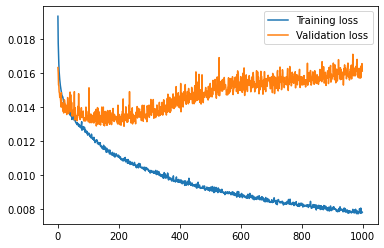

In [63]:
# plot metrics
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='Training loss')
pyplot.plot(history.history['val_loss'], label='Validation loss')

# pyplot.plot(history.history['mean_absolute_percentage_error'])
plt.legend()
pyplot.show()

In [69]:
print(history.history.keys())
print(np.argmin(np.array(history.history['val_loss']))+1)

yhat = model.predict(X_test, verbose=1)
yp = y_scaler.inverse_transform(yhat)
ya = y_scaler.inverse_transform(y_test)

dict_keys(['val_loss', 'loss'])
218
2537/2537 [==============================] - 0s 28us/step


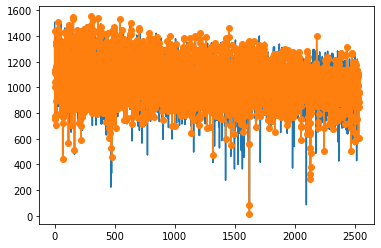

In [70]:
# T1
plt.plot(ya[:,:1])
plt.plot(yp[:,:1],marker='o')